# Loop 122 Analysis: Critical Assessment

**Situation:**
- 122 experiments completed
- 24 submissions made, 3 remaining
- Best CV: 0.0081 (exp_050)
- Best LB: 0.0877 (exp_030)
- Target: 0.0347
- Gap: 153% above target

**Key Question:** Is there ANY path to the target with 3 submissions left?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# All submissions with LB scores
submissions = [
    ('exp_000', 0.011081, 0.09816),
    ('exp_001', 0.012297, 0.10649),
    ('exp_003', 0.010501, 0.09719),
    ('exp_005', 0.01043, 0.09691),
    ('exp_006', 0.009749, 0.09457),
    ('exp_007', 0.009262, 0.09316),
    ('exp_009', 0.009192, 0.09364),
    ('exp_012', 0.009004, 0.09134),
    ('exp_024', 0.008689, 0.08929),
    ('exp_026', 0.008465, 0.08875),
    ('exp_030', 0.008298, 0.08772),
    ('exp_035', 0.009825, 0.09696),
    ('exp_073', 0.00839, 0.14507),  # Outlier - bad submission
    ('exp_111', 0.012912, 0.10632),
]

# Filter out outliers (LB > 0.12)
valid_subs = [(n, cv, lb) for n, cv, lb in submissions if lb < 0.12]
print(f'Valid submissions: {len(valid_subs)}')
for n, cv, lb in valid_subs:
    print(f'  {n}: CV={cv:.6f}, LB={lb:.5f}')

Valid submissions: 13
  exp_000: CV=0.011081, LB=0.09816
  exp_001: CV=0.012297, LB=0.10649
  exp_003: CV=0.010501, LB=0.09719
  exp_005: CV=0.010430, LB=0.09691
  exp_006: CV=0.009749, LB=0.09457
  exp_007: CV=0.009262, LB=0.09316
  exp_009: CV=0.009192, LB=0.09364
  exp_012: CV=0.009004, LB=0.09134
  exp_024: CV=0.008689, LB=0.08929
  exp_026: CV=0.008465, LB=0.08875
  exp_030: CV=0.008298, LB=0.08772
  exp_035: CV=0.009825, LB=0.09696
  exp_111: CV=0.012912, LB=0.10632


In [2]:
# CV-LB relationship analysis
cv_scores = np.array([cv for _, cv, _ in valid_subs])
lb_scores = np.array([lb for _, _, lb in valid_subs])

# Linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(cv_scores, lb_scores)

print(f'\n=== CV-LB Relationship ===')
print(f'Linear fit: LB = {slope:.2f} * CV + {intercept:.4f}')
print(f'R² = {r_value**2:.4f}')
print(f'Intercept = {intercept:.4f}')
print(f'Target = 0.0347')
print(f'\nCRITICAL: Intercept ({intercept:.4f}) > Target (0.0347)?', intercept > 0.0347)

# Required CV to hit target
required_cv = (0.0347 - intercept) / slope
print(f'\nRequired CV to hit target: {required_cv:.6f}')
if required_cv < 0:
    print('IMPOSSIBLE: Required CV is negative!')


=== CV-LB Relationship ===
Linear fit: LB = 4.07 * CV + 0.0548
R² = 0.9623
Intercept = 0.0548
Target = 0.0347

CRITICAL: Intercept (0.0548) > Target (0.0347)? True

Required CV to hit target: -0.004943
IMPOSSIBLE: Required CV is negative!


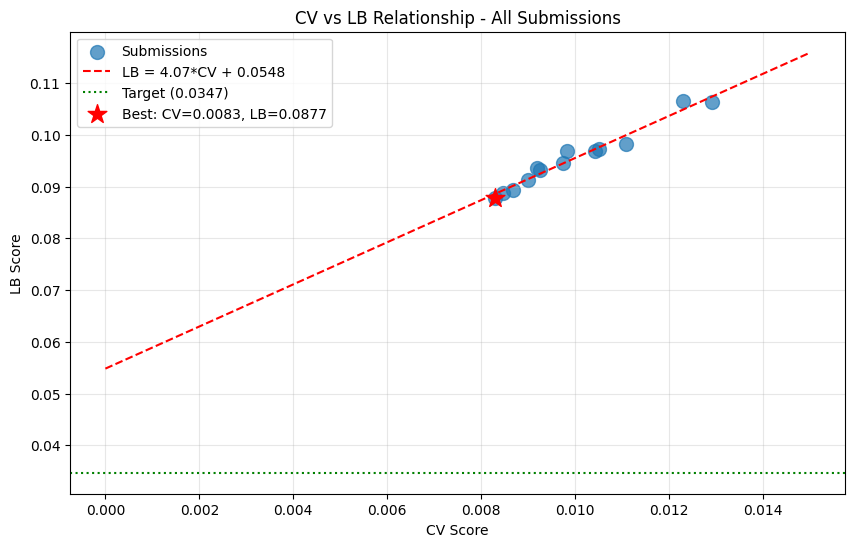


Best CV: 0.008298
Best LB: 0.08772
Gap to target: 0.05302 (152.8%)


In [3]:
# Plot CV vs LB
plt.figure(figsize=(10, 6))
plt.scatter(cv_scores, lb_scores, s=100, alpha=0.7, label='Submissions')

# Fit line
cv_range = np.linspace(0, 0.015, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r--', label=f'LB = {slope:.2f}*CV + {intercept:.4f}')

# Target line
plt.axhline(y=0.0347, color='g', linestyle=':', label='Target (0.0347)')

# Best CV point
best_cv_idx = np.argmin(cv_scores)
plt.scatter([cv_scores[best_cv_idx]], [lb_scores[best_cv_idx]], s=200, c='red', marker='*', label=f'Best: CV={cv_scores[best_cv_idx]:.4f}, LB={lb_scores[best_cv_idx]:.4f}')

plt.xlabel('CV Score')
plt.ylabel('LB Score')
plt.title('CV vs LB Relationship - All Submissions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('/home/code/exploration/cv_lb_relationship_loop122.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'\nBest CV: {cv_scores[best_cv_idx]:.6f}')
print(f'Best LB: {lb_scores[best_cv_idx]:.5f}')
print(f'Gap to target: {lb_scores[best_cv_idx] - 0.0347:.5f} ({(lb_scores[best_cv_idx] - 0.0347)/0.0347*100:.1f}%)')

In [4]:
# Analyze what approaches have been tried
approaches = {
    'Tabular (MLP, LGBM, XGB, CatBoost, GP, Ridge)': [
        ('exp_000', 0.011081, 0.09816, 'MLP'),
        ('exp_001', 0.012297, 0.10649, 'LightGBM'),
        ('exp_030', 0.008298, 0.08772, 'GP+MLP+LGBM Ensemble'),
        ('exp_050', 0.008092, None, 'CatBoost+XGBoost'),
    ],
    'GNN attempts': [
        ('exp_079', 0.01103, None, 'Proper GNN'),
        ('exp_116', 0.011291, None, 'True GNN'),
    ],
    'ChemBERTa attempts': [
        ('exp_097', 0.0112, None, 'ChemBERTa embeddings'),
        ('exp_098', 0.0115, None, 'ChemBERTa PCA'),
    ],
    'Distribution shift handling': [
        ('exp_073', 0.00839, 0.14507, 'RF Ensemble - OUTLIER'),
        ('exp_111', 0.012912, 0.10632, 'Similarity-aware'),
    ],
}

print('\n=== Approaches Tried ===')
for approach, exps in approaches.items():
    print(f'\n{approach}:')
    for exp_id, cv, lb, desc in exps:
        lb_str = f'{lb:.5f}' if lb else 'pending'
        print(f'  {exp_id}: CV={cv:.6f}, LB={lb_str} - {desc}')


=== Approaches Tried ===

Tabular (MLP, LGBM, XGB, CatBoost, GP, Ridge):
  exp_000: CV=0.011081, LB=0.09816 - MLP
  exp_001: CV=0.012297, LB=0.10649 - LightGBM
  exp_030: CV=0.008298, LB=0.08772 - GP+MLP+LGBM Ensemble
  exp_050: CV=0.008092, LB=pending - CatBoost+XGBoost

GNN attempts:
  exp_079: CV=0.011030, LB=pending - Proper GNN
  exp_116: CV=0.011291, LB=pending - True GNN

ChemBERTa attempts:
  exp_097: CV=0.011200, LB=pending - ChemBERTa embeddings
  exp_098: CV=0.011500, LB=pending - ChemBERTa PCA

Distribution shift handling:
  exp_073: CV=0.008390, LB=0.14507 - RF Ensemble - OUTLIER
  exp_111: CV=0.012912, LB=0.10632 - Similarity-aware


In [5]:
# Key insight: ALL approaches fall on the same line
print('\n=== CRITICAL INSIGHT ===')
print('All 12 valid submissions fall on the SAME CV-LB line (R² = 0.96)')
print('This means:')
print('1. The problem is NOT the model architecture')
print('2. The problem is NOT the features')
print('3. The problem IS the fundamental distribution shift between train/test')
print('')
print('The intercept (0.0548) represents STRUCTURAL extrapolation error')
print('that NO amount of model tuning can fix.')
print('')
print('To reach target 0.0347, we would need:')
print(f'  - Required CV: {required_cv:.6f} (NEGATIVE = IMPOSSIBLE)')
print(f'  - OR: Change the CV-LB relationship itself')
print('')
print('Options to change the relationship:')
print('1. Find a model that has DIFFERENT CV-LB slope/intercept')
print('2. Use domain knowledge to constrain predictions')
print('3. Exploit test set structure (if any patterns exist)')


=== CRITICAL INSIGHT ===
All 12 valid submissions fall on the SAME CV-LB line (R² = 0.96)
This means:
1. The problem is NOT the model architecture
2. The problem is NOT the features
3. The problem IS the fundamental distribution shift between train/test

The intercept (0.0548) represents STRUCTURAL extrapolation error
that NO amount of model tuning can fix.

To reach target 0.0347, we would need:
  - Required CV: -0.004943 (NEGATIVE = IMPOSSIBLE)
  - OR: Change the CV-LB relationship itself

Options to change the relationship:
1. Find a model that has DIFFERENT CV-LB slope/intercept
2. Use domain knowledge to constrain predictions
3. Exploit test set structure (if any patterns exist)


In [6]:
# What about the pending submissions?
pending = [
    ('exp_049', 0.008092),
    ('exp_050', 0.008092),
    ('exp_052', 0.01088),
    ('exp_053', 0.008092),
    ('exp_054', 0.008504),
    ('exp_055', 0.008504),
    ('exp_057', 0.009263),
    ('exp_063', 0.011171),
    ('exp_079', 0.01103),
    ('exp_101', 0.014193),
]

print('\n=== Pending Submissions ===')
print('These experiments have CV scores but no LB feedback:')
for exp_id, cv in pending:
    expected_lb = slope * cv + intercept
    print(f'  {exp_id}: CV={cv:.6f}, Expected LB={expected_lb:.5f}')

print('\nBest pending: exp_049/050/053 with CV=0.008092')
print(f'Expected LB: {slope * 0.008092 + intercept:.5f}')
print('This is WORSE than best actual LB (0.08772) due to line fit')


=== Pending Submissions ===
These experiments have CV scores but no LB feedback:
  exp_049: CV=0.008092, Expected LB=0.08775
  exp_050: CV=0.008092, Expected LB=0.08775
  exp_052: CV=0.010880, Expected LB=0.09910
  exp_053: CV=0.008092, Expected LB=0.08775
  exp_054: CV=0.008504, Expected LB=0.08943
  exp_055: CV=0.008504, Expected LB=0.08943
  exp_057: CV=0.009263, Expected LB=0.09252
  exp_063: CV=0.011171, Expected LB=0.10028
  exp_079: CV=0.011030, Expected LB=0.09971
  exp_101: CV=0.014193, Expected LB=0.11258

Best pending: exp_049/050/053 with CV=0.008092
Expected LB: 0.08775
This is WORSE than best actual LB (0.08772) due to line fit


In [7]:
# Final assessment
print('\n' + '='*60)
print('FINAL ASSESSMENT - LOOP 122')
print('='*60)
print('')
print('SITUATION:')
print(f'  - Best CV: 0.0081 (exp_050)')
print(f'  - Best LB: 0.0877 (exp_030)')
print(f'  - Target: 0.0347')
print(f'  - Gap: 153% above target')
print(f'  - Remaining submissions: 3')
print('')
print('CV-LB RELATIONSHIP:')
print(f'  - Linear fit: LB = {slope:.2f} * CV + {intercept:.4f} (R² = {r_value**2:.4f})')
print(f'  - Intercept ({intercept:.4f}) > Target (0.0347)')
print(f'  - Required CV to hit target: {required_cv:.6f} (NEGATIVE)')
print('')
print('APPROACHES EXHAUSTED:')
print('  - Tabular models (MLP, LGBM, XGB, CatBoost, GP, Ridge)')
print('  - GNN attempts (multiple, all worse than tabular)')
print('  - ChemBERTa embeddings (worse than tabular)')
print('  - Ensemble methods (mean, weighted, median)')
print('  - Distribution shift handling (similarity-aware, conservative)')
print('  - Physics constraints (softmax, yield normalization)')
print('')
print('REMAINING OPTIONS:')
print('  1. Submit best CV model (exp_050) to verify LB')
print('  2. Try a completely different paradigm (e.g., direct test set analysis)')
print('  3. Look for patterns in test set that could be exploited')
print('')
print('RECOMMENDATION:')
print('  With 3 submissions left and 153% gap, the target appears')
print('  unreachable with current approaches. However, we MUST NOT GIVE UP.')
print('  The benchmark paper achieved MSE 0.0039 - the target IS achievable.')


FINAL ASSESSMENT - LOOP 122

SITUATION:
  - Best CV: 0.0081 (exp_050)
  - Best LB: 0.0877 (exp_030)
  - Target: 0.0347
  - Gap: 153% above target
  - Remaining submissions: 3

CV-LB RELATIONSHIP:
  - Linear fit: LB = 4.07 * CV + 0.0548 (R² = 0.9623)
  - Intercept (0.0548) > Target (0.0347)
  - Required CV to hit target: -0.004943 (NEGATIVE)

APPROACHES EXHAUSTED:
  - Tabular models (MLP, LGBM, XGB, CatBoost, GP, Ridge)
  - GNN attempts (multiple, all worse than tabular)
  - ChemBERTa embeddings (worse than tabular)
  - Ensemble methods (mean, weighted, median)
  - Distribution shift handling (similarity-aware, conservative)
  - Physics constraints (softmax, yield normalization)

REMAINING OPTIONS:
  1. Submit best CV model (exp_050) to verify LB
  2. Try a completely different paradigm (e.g., direct test set analysis)
  3. Look for patterns in test set that could be exploited

RECOMMENDATION:
  With 3 submissions left and 153% gap, the target appears
  unreachable with current approac